In [2]:
%load_ext autoreload
%autoreload 2

from CauseML.parameters import build_parameters_from_metric_levels
from CauseML.constants import Constants
from CauseML.data_generation import DataGeneratingProcessWrapper
import CauseML.data_sources as data_sources
from CauseML.utilities import extract_treat_and_control_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as mse

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def build_mlp():
    return MLPRegressor(
        hidden_layer_sizes=(50, 25, 10),
        activation='relu',
        solver='adam',
        batch_size='auto',
        learning_rate='constant',
        learning_rate_init=0.001,
        power_t=0.5,
        max_iter=1000,
        shuffle=True,
        random_state=1,
        tol=0.0001,
        verbose=False,
        warm_start=False,
        early_stopping=True,
        validation_fraction=0.10,
        epsilon=1e-08,
        n_iter_no_change=5)

In [6]:
def generate_data(
    prop_score=0.5,
    n_covars=20,
    n_observations=50000):
    
    covar_data_source = data_sources.load_random_normal_covariates(
        n_covars=n_covars,
        n_observations=n_observations,
        partial_correlation_degree=0.1)

    dgp_params = build_parameters_from_metric_levels({
        Constants.MetricNames.TREATMENT_NONLINEARITY: Constants.MetricLevels.LOW,
        Constants.MetricNames.OUTCOME_NONLINEARITY: Constants.MetricLevels.LOW,
        Constants.MetricNames.TE_HETEROGENEITY: Constants.MetricLevels.LOW
    })
    
    dgp_params.set_parameter("MIN_PROPENSITY_SCORE", 0.001)
    dgp_params.set_parameter("MAX_PROPENSITY_SCORE", 0.9999)
    dgp_params.set_parameter("TREATMENT_EFFECT_HETEROGENEITY", 0.05)
    dgp_params.set_parameter("OUTCOME_NOISE_TAIL_THICKNESS", 300)
    dgp_params.set_parameter("TARGET_PROPENSITY_SCORE", prop_score)
#     dgp_params.set_parameter("TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY",
#                              {
#                                 "LINEAR": 1,
#                                 "POLY_QUAD": 0.0,
#                                 "POLY_CUBIC": 0.0,
#                                 "STEP_JUMP": 0,
#                                 "STEP_KINK": 0,
#                                 "INTERACTION_TWO_WAY": 0,
#                                 "INTERACTION_THREE_WAY": 0
#                              })
#     dgp_params.set_parameter("OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY",
#                              {
#                                 "LINEAR": 1,
#                                 "POLY_QUAD": 0.0,
#                                 "POLY_CUBIC": 0.0,
#                                 "STEP_JUMP": 0.05,
#                                 "STEP_KINK": 0,
#                                 "INTERACTION_TWO_WAY": 0,
#                                 "INTERACTION_THREE_WAY": 0
#                              })

    dgp_wrapper = DataGeneratingProcessWrapper(
        parameters=dgp_params, data_source=covar_data_source)

    dgp_wrapper.sample_dgp()

    _ = dgp_wrapper.generate_data()
    
    obs_data = dgp_wrapper.get_observed_data()
    oracle_data = dgp_wrapper.get_oracle_data()
    
    return obs_data, oracle_data

In [12]:
observed_data, unobservable_data = generate_data(prop_score=0.5)
observed_data.head()

,T,Y,X0,X1,X2,X3,X4,X5,X6,X7,...,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19
25263,1,0.244919,0.074285,-0.458034,-0.042549,-0.062885,0.013582,-0.040410,0.035290,0.105273,...,0.392851,-0.111192,0.212043,-0.120007,-0.217505,-0.089801,-0.276038,-0.252135,0.012416,-0.047995
40631,0,-0.315248,0.020221,0.072061,0.037275,-0.154855,-0.242792,0.031115,0.284953,-0.167545,...,-0.100991,-0.468550,0.033444,-0.100431,0.362265,-0.056477,0.339392,0.145366,0.252079,0.055075
9751,0,0.590284,0.225186,-0.172144,-0.060696,0.261099,0.003667,-0.260881,-0.152487,0.197730,...,-0.257062,0.227827,0.270138,0.107714,-0.257160,-0.343878,0.068046,-0.248606,0.300576,0.129520
2817,0,-1.166874,-0.126949,0.029927,-0.333142,-0.198859,0.187568,-0.122312,0.140900,0.162323,...,0.113884,-0.277389,0.000654,-0.174227,-0.035104,0.345181,-0.023110,-0.107066,0.189049,-0.308572
35873,1,-2.037702,-0.176896,0.309902,0.133364,0.180438,-0.037667,-0.146259,-0.088651,-0.044983,...,-0.380661,0.139664,0.183469,0.472300,-0.630373,-0.195870,0.190585,-0.270072,0.115190,-0.157574


In [13]:
unobservable_data.head()

,logit(P(T|X)),P(T|X),Y0,Y1,TE,TRANSFORMED_X0,TRANSFORMED_X1,TRANSFORMED_X2,TRANSFORMED_X3,TRANSFORMED_X4,...,TRANSFORMED_X23,TRANSFORMED_X24,TRANSFORMED_X25,TRANSFORMED_X26,TRANSFORMED_X27,TRANSFORMED_X28,TRANSFORMED_X29,TRANSFORMED_X30,TRANSFORMED_X31,NOISE(Y)
25263,2.095762,0.890491,1.174919,0.244919,-0.93,-0.009053,0.009508,0.005478,0.005423,0.076477,...,0.000737,-0.000468,-0.020734,0.070537,-0.000261,0.008250,0.042139,0.011745,0.007031,0.078
40631,-1.669935,0.158433,-0.315248,-1.245248,-0.93,0.014409,0.002588,0.003445,0.001476,-0.023992,...,-0.001173,-0.000251,0.023792,-0.011097,-0.005294,-0.002121,-0.006630,-0.019562,-0.005414,0.170
9751,1.631290,0.836346,0.590284,-0.339716,-0.93,-0.017005,0.028824,0.020977,0.016439,0.070632,...,0.001384,0.000381,0.055953,0.026510,-0.006312,-0.005398,0.015837,0.013887,0.045393,-0.090
2817,-0.801068,0.309797,-1.166874,-2.096874,-0.93,-0.013960,-0.016249,-0.021056,-0.009267,-0.017721,...,0.001136,-0.000599,-0.133303,-0.004609,-0.003970,0.002392,-0.002753,0.001896,0.021282,0.173
35873,-0.588698,0.356934,-1.107702,-2.037702,-0.93,0.003869,-0.022643,0.011948,-0.012913,-0.017849,...,-0.000315,0.000508,-0.068072,-0.047725,-0.002419,-0.007994,-0.028511,0.034040,0.025449,0.174


In [11]:
def score_ITE(ITE_true, ITE_pred):
    return mse(ITE_true, ITE_pred)

In [12]:
def T_learner(data):
    treated_data, control_data = extract_treat_and_control_data(
        data, data["T"])
    
    # train u1
    u1 = build_mlp()
    X_treated = treated_data.drop(["T", "Y"], axis=1)
    u1.fit(X_treated, treated_data["Y"])
    
    # train u0
    u0 = build_mlp()
    X_control = control_data.drop(["T", "Y"], axis=1)
    u0.fit(X_control, control_data["Y"])
    
    # Generate potential outcome predictions
    X = data.drop(["T", "Y"], axis=1)
    y_1_predicted = u1.predict(X)
    y_0_predicted = u0.predict(X)
    
    ITE_pred = y_1_predicted - y_0_predicted
    
    return ITE_pred, u1, u0

In [13]:
def S_learner(data):
    # train u1
    u = build_mlp()
    X = data.drop("Y", axis=1)
    u.fit(X, data["Y"])
    
    # Generate potential outcomes
    X_under_treatment = X.copy()
    X_under_treatment["T"] = 1
    
    X_under_control = X.copy()
    X_under_control["T"] = 0
    
    y_1_predicted = u.predict(X_under_treatment)
    y_0_predicted = u.predict(X_under_control)
    y_1_predicted - y_0_predicted
    
    ITE_pred = y_1_predicted - y_0_predicted
    
    return  ITE_pred

In [14]:
def X_learner(data, u1=None, u0=None):
    treated_data, control_data = extract_treat_and_control_data(
        data, data["T"])
    X_treated = treated_data.drop(["T", "Y"], axis=1)
    X_control = control_data.drop(["T", "Y"], axis=1)

    if u1 is None:
        # train u1
        u1 = build_mlp()
        u1.fit(X_treated, treated_data["Y"])
    
    if u0 is None:
        # train u0
        u0 = build_mlp()
        u0.fit(X_control, control_data["Y"])
    
    # Find individual treatment effects for treated/controls
    itet = treated_data["Y"] - u0.predict(X_treated)
    itec =  u1.predict(X_control) - control_data["Y"]
    
    # Fit models to the treated and controls
    te1 = build_mlp()
    te1.fit(X_treated, itet)
    
    te0 = build_mlp()
    te0.fit(X_control, itec)
    
    X = data.drop(["T", "Y"], axis=1)
    te1_predicted = te1.predict(X)
    te0_predicted = te0.predict(X)
    
    # Estimate prop scores
    lm = LogisticRegression(solver="lbfgs")
    lm.fit(X, data["T"])
    prop_scores = lm.predict(X)
    
    # Down-weight observes which are likely to belong
    # to other class.
    te = prop_scores*te0_predicted + (1-prop_scores)*te1_predicted
    
    return te

In [15]:
ITE_pred, _, _ = T_learner(observed_data)
score_ITE(ITE_true, ITE_pred)

NameError: name 'observed_data' is not defined

In [16]:
ITE_pred = S_learner(observed_data)
score_ITE(ITE_true, ITE_pred)

NameError: name 'observed_data' is not defined

In [ ]:
ITE_pred = X_learner(observed_data)
score_ITE(ITE_true, ITE_pred)

In [17]:
def run_trial(prop_score=0.5, n_covars=20, n_observations=50000):
    observed_data, unobservable_data = generate_data(
        prop_score=prop_score,
        n_covars=n_covars,
        n_observations=n_observations)
    
    ITE_true = unobservable_data["TE"]
    
    # T learner
    ITE_pred, u1, u0 = T_learner(observed_data)
    T_loss = score_ITE(ITE_true, ITE_pred)
    
    # S learner
    ITE_pred = S_learner(observed_data)
    S_loss = score_ITE(ITE_true, ITE_pred)
    
    # X learner
    ITE_pred = X_learner(observed_data, u1, u0)
    X_loss = score_ITE(ITE_true, ITE_pred)
    
    return T_loss, S_loss, X_loss

In [18]:
# N_obs = np.logspace(3, 4, 6).astype(int)
N_obs = [100000, 200000, 300000]

In [19]:
%%time

results = []
N_trials = 1
for n_obs in N_obs:
    print("Running at n:", n_obs)
    trial_results = []
    for _ in range(N_trials):
        res = run_trial(prop_score=0.02, n_observations=n_obs)
        trial_results.append(res)
        
    
    trial_results = np.array(trial_results)
    results.append(np.mean(trial_results, axis=0))

Running at n: 100000


KeyboardInterrupt: 

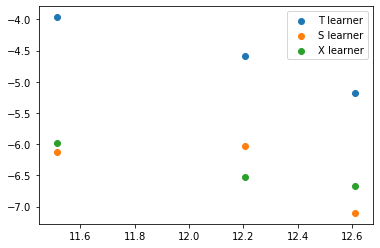

In [37]:
results = np.array(results)
names = ["T learner", "S learner", "X learner"]
for i, name in enumerate(names):
    plt.scatter(np.log(N_obs), np.log(results[:, i]), label=name)

plt.legend()
plt.show()